In [1]:
import pandas as pd
from fredapi import Fred
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # type: ignore
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import shap
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score

c:\Users\jdean\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize FRED with your API key
fred = Fred(api_key='badde7b0bf5a6441f7da522af157a338 ')  # Replace with your key

# Define series IDs
series_ids = {
    'GDP': 'GDP',
    'Industrial_Production' : 'INDPRO',
    'Jobs': 'UNRATE',
    'Heavy_Vehicle_Sales': 'HTRUCKSSAAR',
    'Building_Permits': 'Permit',
    'Employment_Claims': 'IC4WSA',
    'Recession': 'USREC'
}

# Fetch data
data = {}
for name, series_id in series_ids.items():
    data[name] = fred.get_series(series_id)

# Combine into a DataFrame
df = pd.DataFrame(data)

# Resample to month-end
df = df.resample('ME').last()

if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

In [ ]:
# Interpolate GDP from quarterly to monthly
df['GDP'] = df['GDP'].interpolate(method='linear')

# Calculate GDP growth rate and NASDAQ return
df['GDP_Growth'] = df['GDP'].pct_change() * 100
df['GDP_Growth'] = df['GDP_Growth'].ffill()
#df['NASDAQ_Return'] = df['Stock_Market'].pct_change() * 100
#df['NASDAQ_Return'] = df['NASDAQ_Return'].ffill()

#df['Jobs'] = df['Jobs'].diff()

# Trim to where all core series have data
df = df.dropna()

# Add recession targets for different horizons
df['Recession_Next_3M'] = df['Recession'].shift(-3)
df['Recession_Next_6M'] = df['Recession'].shift(-6)
df['Recession_Next_12M'] = df['Recession'].shift(-12)


# Cut off at last full month, dynamically based on current date
#today = datetime.today()  # Gets current date and time
#last_week = today - timedelta(days=7)  # One week back
#last_full_month = last_week.replace(day=1) - timedelta(days=1)  # End of previous month
#df_full = df.loc[:last_full_month.strftime('%Y-%m-%d')].copy()


df_full = df

# Convert row names (index) to a column called 'Date'
df_full = df_full.reset_index()
df_full = df_full.rename(columns={'index': 'Date'})  # If your index is unnamed

# Or if your index already has a name:
#df_full = df_full.reset_index()

# Now add the regime column
df_full['Regime'] = df_full['Date'].dt.year.apply(
    lambda x: '1960s to 1984' if x < 1985 else 
             '1977-1984' if x < 1985 and x >= 1977 else 
             '2000s'
)





In [28]:
# Training data for each horizon
df_train_3m = df_full.dropna(subset=['Recession_Next_3M'])
df_train_6m = df_full.dropna(subset=['Recession_Next_6M'])
df_train_12m = df_full.dropna(subset=['Recession_Next_12M'])

# Features
features = ['Building_Permits', 'Employment_Claims' , 'Jobs', 'Industrial_Production']

# 3-month horizon
X_3m = df_train_3m[features]
y_3m = df_train_3m['Recession_Next_3M']
X_train_3m, X_test_3m, y_train_3m, y_test_3m = train_test_split(X_3m, y_3m, test_size=0.2, random_state=42)
scaler_3m = StandardScaler()
X_train_scaled_3m = scaler_3m.fit_transform(X_train_3m)
X_test_scaled_3m = scaler_3m.transform(X_test_3m)
model_3m = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_3m.fit(X_train_scaled_3m, y_train_3m)

# 6-month horizon
X_6m = df_train_6m[features]
y_6m = df_train_6m['Recession_Next_6M']
X_train_6m, X_test_6m, y_train_6m, y_test_6m = train_test_split(X_6m, y_6m, test_size=0.2, random_state=42)
scaler_6m = StandardScaler()
X_train_scaled_6m = scaler_6m.fit_transform(X_train_6m)
X_test_scaled_6m = scaler_6m.transform(X_test_6m)
model_6m = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_6m.fit(X_train_scaled_6m, y_train_6m)

# 12-month horizon
X_12m = df_train_12m[features]
y_12m = df_train_12m['Recession_Next_12M']
X_train_12m, X_test_12m, y_train_12m, y_test_12m = train_test_split(X_12m, y_12m, test_size=0.2, random_state=42)
scaler_12m = StandardScaler()
X_train_scaled_12m = scaler_12m.fit_transform(X_train_12m)
X_test_scaled_12m = scaler_12m.transform(X_test_12m)
model_12m = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_12m.fit(X_train_scaled_12m, y_train_12m)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
def rolling_random_forest_out_of_sample(df, features, target_col, window, 
                                      n_estimators=100, class_weight='balanced'):
    """
    Rolling Random Forest that predicts the next period out-of-sample
    """
    accuracy_scores = []
    log_losses = []
    auc_scores = []
    precision_scores = []
    recall_scores = []
    predicted_probabilities = []
    predicted_classes = []
    actual_values = []
    
    indices = []  # Index where we make the prediction (next period)
    
    for i in range(window, len(df) - 1):  # -1 to have next period to predict
        # Training data: current window
        x_train = df[features].iloc[i - window:i].values
        y_train = df[target_col].iloc[i - window:i].values
        
        # Test data: next period (what we want to predict)
        x_test = df[features].iloc[i:i+1].values  # Next period's features
        y_test = df[target_col].iloc[i+1:i+2].values  # Next period's target (actual)
        
        # Check training data has both classes
        if len(np.unique(y_train)) < 2:
            continue
        
        try:
            model = RandomForestClassifier(
                n_estimators=n_estimators, 
                class_weight=class_weight, 
                random_state=42
            )
            
            model.fit(x_train, y_train)
            
            # Predict next period
            y_pred = model.predict(x_test)[0]
            y_pred_proba = model.predict_proba(x_test)[0, 1]  # Prob of recession
            
            # Store prediction (not actual metrics yet since we only have one point)
            indices.append(df.index[i+1])  # Index of the period we're predicting
            predicted_probabilities.append(y_pred_proba)
            predicted_classes.append(y_pred)
            actual_values.append(y_test[0])
            
        except Exception as e:
            continue
    
    # Calculate metrics after we have all predictions
    if len(actual_values) > 0:
        accuracy = accuracy_score(actual_values, predicted_classes)
        logloss = log_loss(actual_values, predicted_probabilities)
        
        try:
            auc = roc_auc_score(actual_values, predicted_probabilities)
        except ValueError:
            auc = np.nan
            
        try:
            precision = precision_score(actual_values, predicted_classes, zero_division=0)
            recall = recall_score(actual_values, predicted_classes, zero_division=0)
        except ValueError:
            precision = np.nan
            recall = np.nan
        
        results_df = pd.DataFrame({
            'predicted_prob': predicted_probabilities,
            'predicted_class': predicted_classes,
            'actual': actual_values,
            'accuracy': [accuracy] * len(predicted_probabilities),
            'log_loss': [logloss] * len(predicted_probabilities),
            'auc': [auc] * len(predicted_probabilities),
            'precision': [precision] * len(predicted_probabilities),
            'recall': [recall] * len(predicted_probabilities)
        }, index=indices)
        
        return results_df
    else:
        return pd.DataFrame()

# Usage for out-of-sample predictions
results_3m_oos = rolling_random_forest_out_of_sample(
    df_train_3m, features, 'Recession_Next_3M', window=24
)

print("3-Month Horizon Results:")
print(results_3m_oos.head())
print("\nFeature importance evolution (first few rows):")
feature_importance_cols = [col for col in results_3m_oos.columns if 'importance_' in col]
print(results_3m_oos[feature_importance_cols].head())

3-Month Horizon Results:
    predicted_prob  predicted_class  actual  accuracy  log_loss       auc  \
35            0.23              0.0     1.0  0.899225  0.870703  0.919598   
36            0.42              0.0     1.0  0.899225  0.870703  0.919598   
37            0.50              0.0     1.0  0.899225  0.870703  0.919598   
38            0.92              1.0     1.0  0.899225  0.870703  0.919598   
39            0.96              1.0     1.0  0.899225  0.870703  0.919598   

    precision    recall  
35   0.777778  0.887324  
36   0.777778  0.887324  
37   0.777778  0.887324  
38   0.777778  0.887324  
39   0.777778  0.887324  

Feature importance evolution (first few rows):
Empty DataFrame
Columns: []
Index: [35, 36, 37, 38, 39]


In [30]:
# Evaluate models
print("3-Month Horizon Classification Report:")
print(classification_report(y_test_3m, model_3m.predict(X_test_scaled_3m)))
print("\n6-Month Horizon Classification Report:")
print(classification_report(y_test_6m, model_6m.predict(X_test_scaled_6m)))
print("\n12-Month Horizon Classification Report:")
print(classification_report(y_test_12m, model_12m.predict(X_test_scaled_12m)))

# Predict probabilities over the entire dataset
X_full_scaled_3m = scaler_3m.transform(df_full[features])
df_full.loc[:, 'Recession_Prob_3M'] = model_3m.predict_proba(X_full_scaled_3m)[:, 1]
X_full_scaled_6m = scaler_6m.transform(df_full[features])
df_full.loc[:, 'Recession_Prob_6M'] = model_6m.predict_proba(X_full_scaled_6m)[:, 1]
X_full_scaled_12m = scaler_12m.transform(df_full[features])
df_full.loc[:, 'Recession_Prob_12M'] = model_12m.predict_proba(X_full_scaled_12m)[:, 1]

# Predict probabilities for latest data
X_latest = df_full[features].tail(1)
latest_prob_3m = model_3m.predict_proba(scaler_3m.transform(X_latest))[0, 1]
latest_prob_6m = model_6m.predict_proba(scaler_6m.transform(X_latest))[0, 1]
latest_prob_12m = model_12m.predict_proba(scaler_12m.transform(X_latest))[0, 1]

3-Month Horizon Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       125
         1.0       1.00      0.81      0.90        16

    accuracy                           0.98       141
   macro avg       0.99      0.91      0.94       141
weighted avg       0.98      0.98      0.98       141


6-Month Horizon Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       121
         1.0       0.93      0.68      0.79        19

    accuracy                           0.95       140
   macro avg       0.94      0.84      0.88       140
weighted avg       0.95      0.95      0.95       140


12-Month Horizon Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       120
         1.0       0.86      0.63      0.73        19

    accuracy                           0.94       139
   macro


Predicted probabilities from 703:
  Recession within 3 months: 0.00%
  Recession within 6 months: 2.00%
  Recession within 12 months: 1.00%
Accuracy Scores:
3-Month Horizon: 0.9787
6-Month Horizon: 0.9500
12-Month Horizon: 0.9353

Detailed Metrics:
3-Month - Accuracy: 0.9787, Precision: 1.0000, Recall: 0.8125, F1: 0.8966
6-Month - Accuracy: 0.9500, Precision: 0.9286, Recall: 0.6842, F1: 0.7879
12-Month - Accuracy: 0.9353, Precision: 0.8571, Recall: 0.6316, F1: 0.7273


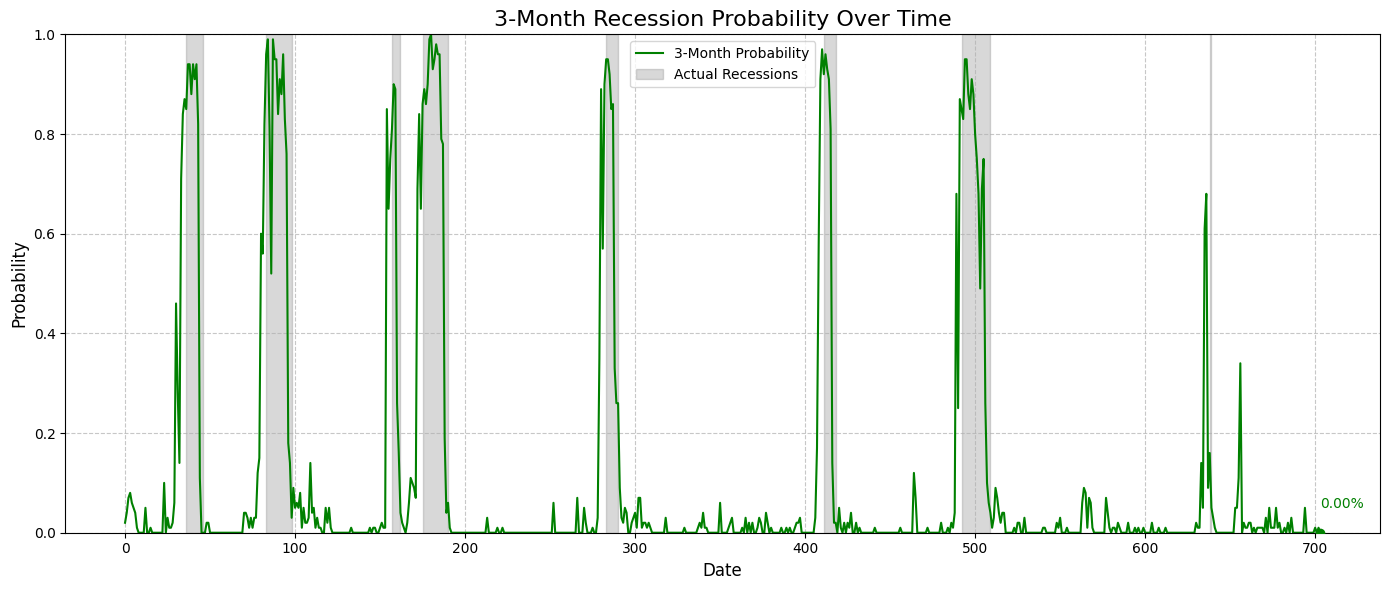

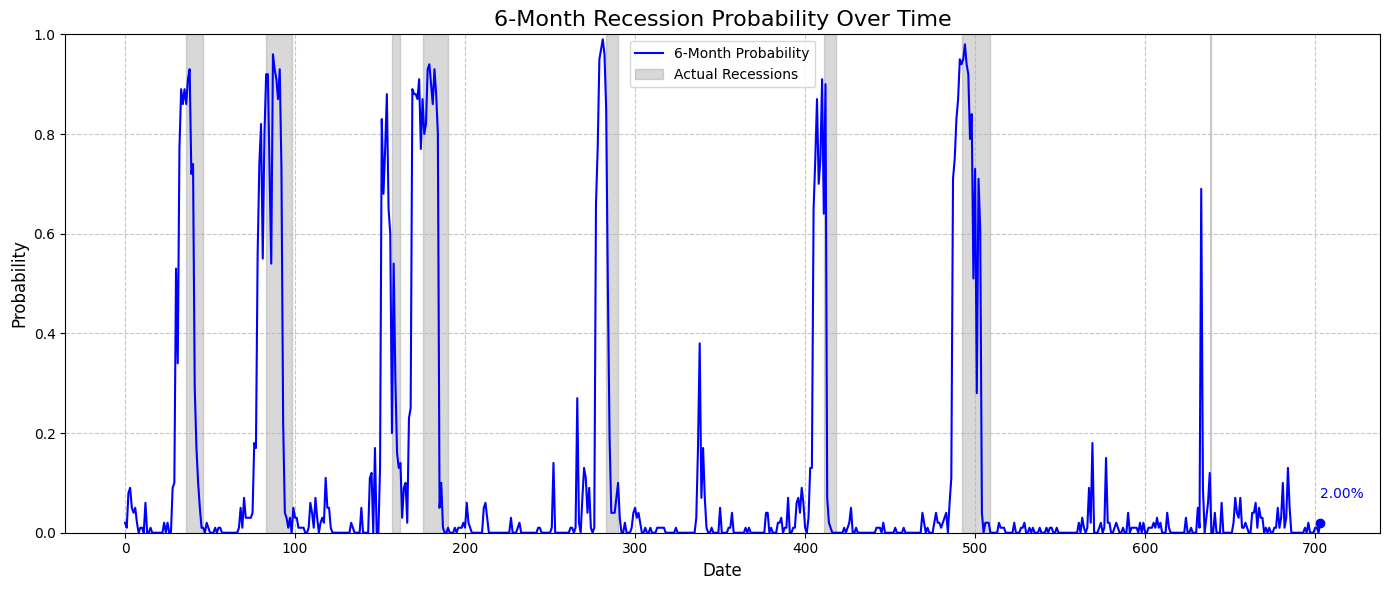

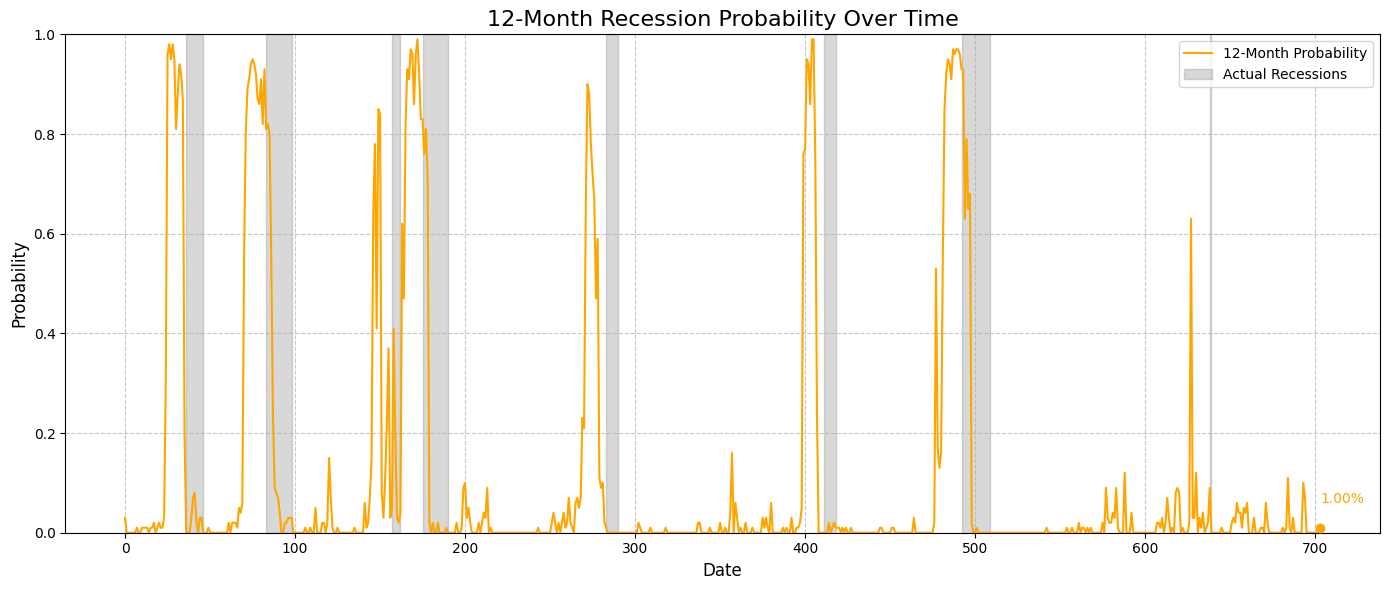

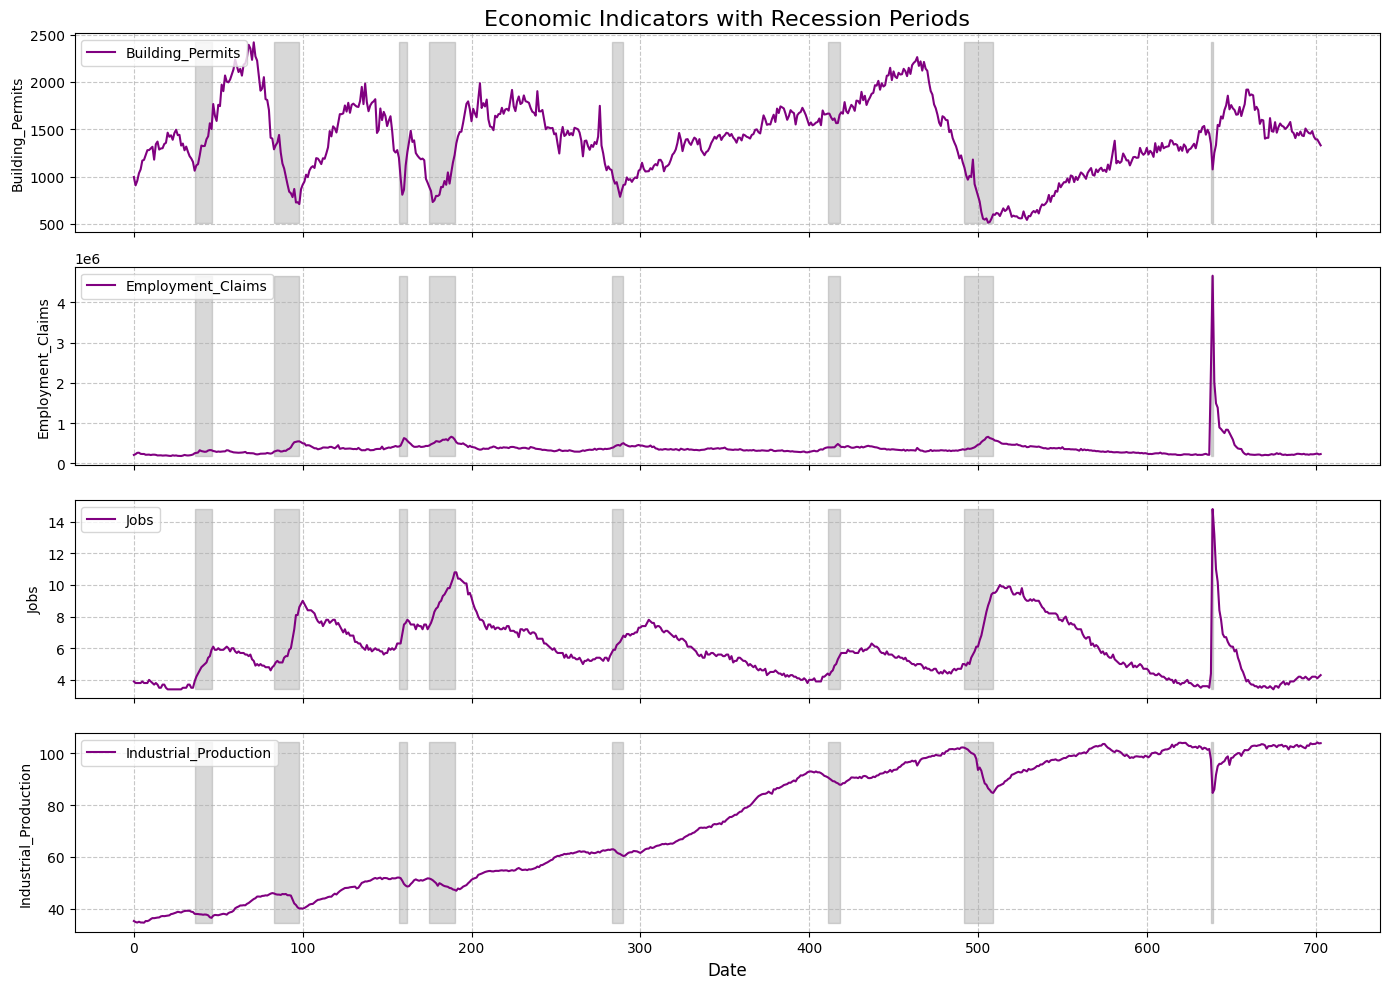

In [31]:
# Display results
print(f"\nPredicted probabilities from {df_full.index[-1]}:")
print(f"  Recession within 3 months: {latest_prob_3m:.2%}")
print(f"  Recession within 6 months: {latest_prob_6m:.2%}")
print(f"  Recession within 12 months: {latest_prob_12m:.2%}")


# Get accuracy scores for each horizon
accuracy_3m = accuracy_score(y_test_3m, model_3m.predict(X_test_scaled_3m))
accuracy_6m = accuracy_score(y_test_6m, model_6m.predict(X_test_scaled_6m))
accuracy_12m = accuracy_score(y_test_12m, model_12m.predict(X_test_scaled_12m))

print("Accuracy Scores:")
print(f"3-Month Horizon: {accuracy_3m:.4f}")
print(f"6-Month Horizon: {accuracy_6m:.4f}")
print(f"12-Month Horizon: {accuracy_12m:.4f}")


# Additional metrics
precision_3m = precision_score(y_test_3m, model_3m.predict(X_test_scaled_3m), zero_division=0)
recall_3m = recall_score(y_test_3m, model_3m.predict(X_test_scaled_3m), zero_division=0)
f1_3m = f1_score(y_test_3m, model_3m.predict(X_test_scaled_3m), zero_division=0)

precision_6m = precision_score(y_test_6m, model_6m.predict(X_test_scaled_6m), zero_division=0)
recall_6m = recall_score(y_test_6m, model_6m.predict(X_test_scaled_6m), zero_division=0)
f1_6m = f1_score(y_test_6m, model_6m.predict(X_test_scaled_6m), zero_division=0)

precision_12m = precision_score(y_test_12m, model_12m.predict(X_test_scaled_12m), zero_division=0)
recall_12m = recall_score(y_test_12m, model_12m.predict(X_test_scaled_12m), zero_division=0)
f1_12m = f1_score(y_test_12m, model_12m.predict(X_test_scaled_12m), zero_division=0)


print("\nDetailed Metrics:")
print(f"3-Month - Accuracy: {accuracy_3m:.4f}, Precision: {precision_3m:.4f}, Recall: {recall_3m:.4f}, F1: {f1_3m:.4f}")
print(f"6-Month - Accuracy: {accuracy_6m:.4f}, Precision: {precision_6m:.4f}, Recall: {recall_6m:.4f}, F1: {f1_6m:.4f}")
print(f"12-Month - Accuracy: {accuracy_12m:.4f}, Precision: {precision_12m:.4f}, Recall: {recall_12m:.4f}, F1: {f1_12m:.4f}")


# Plotting recession probabilities separately for each horizon

# 3-Month Horizon Plot
plt.figure(figsize=(14, 6))
plt.plot(df_full.index, df_full['Recession_Prob_3M'], label='3-Month Probability', color='green')
recession_periods = df_full['Recession'] == 1
plt.fill_between(df_full.index, 0, 1, where=recession_periods, color='gray', alpha=0.3, label='Actual Recessions')
plt.title('3-Month Recession Probability Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.scatter(df_full.index[-1], latest_prob_3m, color='green', zorder=5)
plt.text(df_full.index[-1], latest_prob_3m + 0.05, f'{latest_prob_3m:.2%}', color='green')
plt.tight_layout()
plt.show()

# 6-Month Horizon Plot
plt.figure(figsize=(14, 6))
plt.plot(df_full.index, df_full['Recession_Prob_6M'], label='6-Month Probability', color='blue')
plt.fill_between(df_full.index, 0, 1, where=recession_periods, color='gray', alpha=0.3, label='Actual Recessions')
plt.title('6-Month Recession Probability Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.scatter(df_full.index[-1], latest_prob_6m, color='blue', zorder=5)
plt.text(df_full.index[-1], latest_prob_6m + 0.05, f'{latest_prob_6m:.2%}', color='blue')
plt.tight_layout()
plt.show()

# 12-Month Horizon Plot
plt.figure(figsize=(14, 6))
plt.plot(df_full.index, df_full['Recession_Prob_12M'], label='12-Month Probability', color='orange')
plt.fill_between(df_full.index, 0, 1, where=recession_periods, color='gray', alpha=0.3, label='Actual Recessions')
plt.title('12-Month Recession Probability Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.scatter(df_full.index[-1], latest_prob_12m, color='orange', zorder=5)
plt.text(df_full.index[-1], latest_prob_12m + 0.05, f'{latest_prob_12m:.2%}', color='orange')
plt.tight_layout()
plt.show()

# Plot feature trends with recessions
fig, axes = plt.subplots(len(features), 1, figsize=(14, 10), sharex=True)
for i, feature in enumerate(features):
    axes[i].plot(df_full.index, df_full[feature], label=feature, color='purple')
    axes[i].fill_between(df_full.index, df_full[feature].min(), df_full[feature].max(),
                         where=recession_periods, color='gray', alpha=0.3)
    axes[i].set_ylabel(feature)
    axes[i].legend(loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.7)
axes[0].set_title('Economic Indicators with Recession Periods', fontsize=16)
axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

3-Month Horizon Feature Importance:


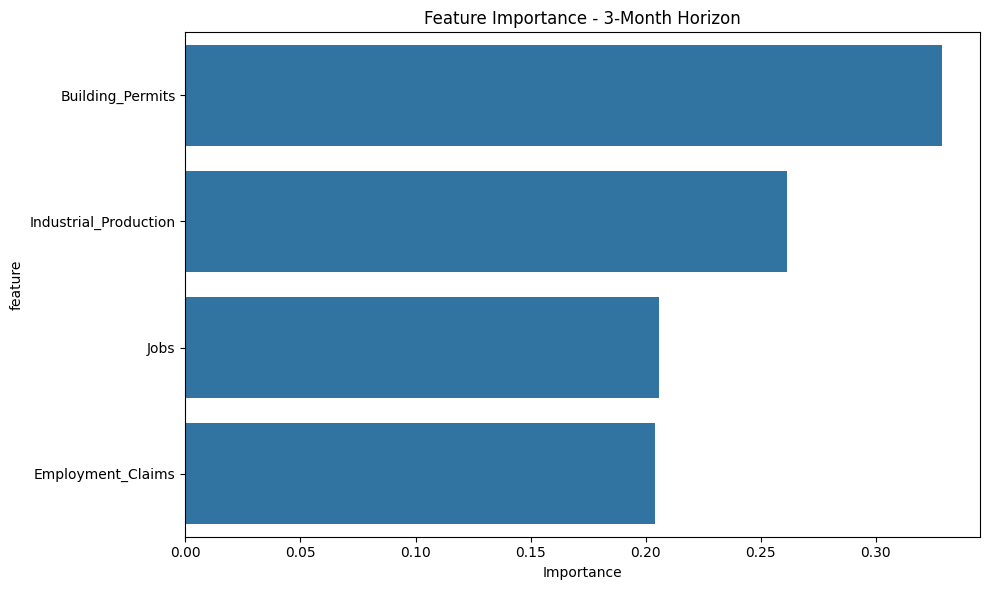


6-Month Horizon Feature Importance:


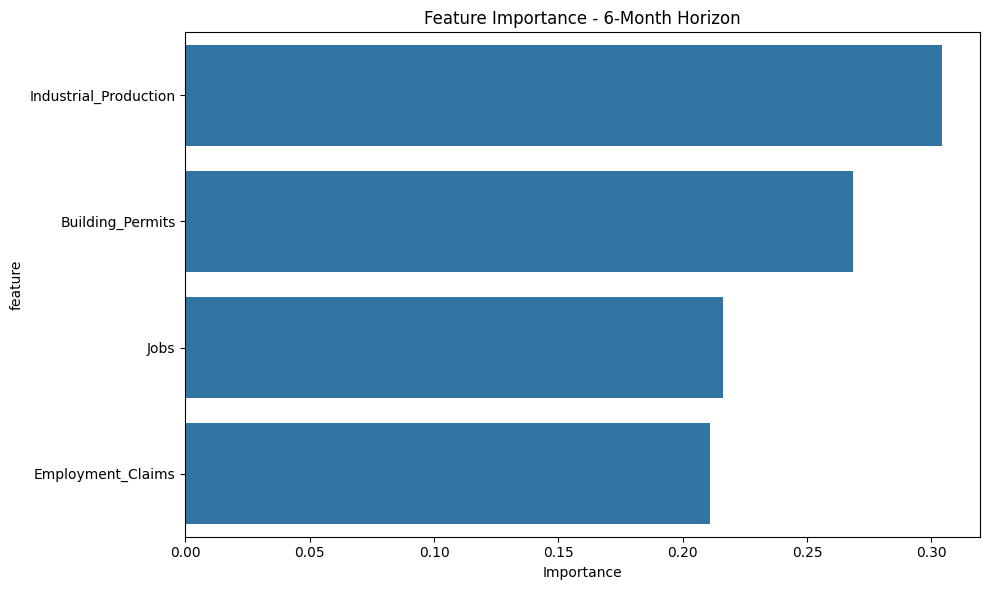


12-Month Horizon Feature Importance:


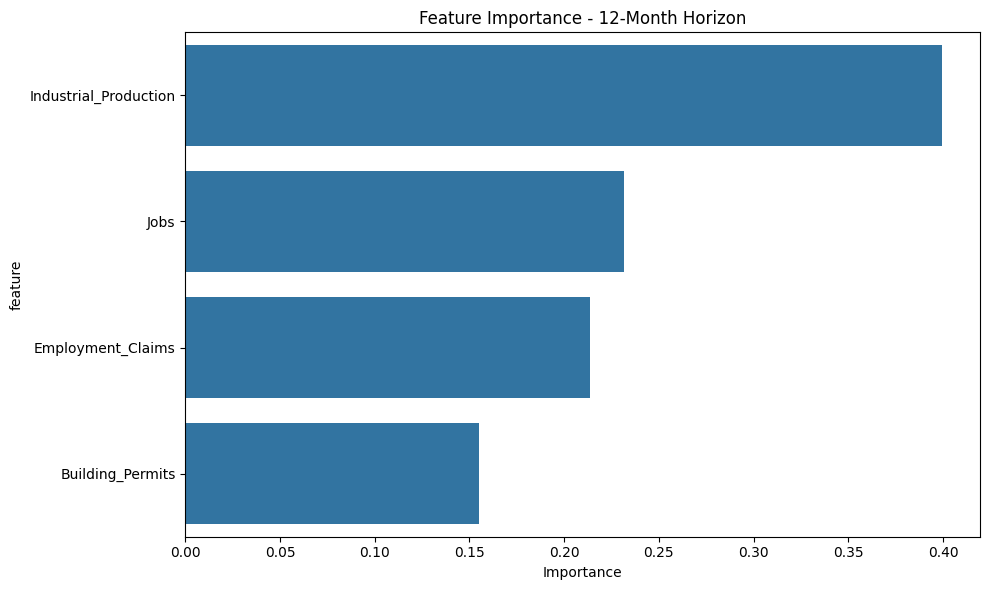

In [32]:
# Function to plot feature importance
def plot_feature_importance(model, features, title, top_n=10):
    # Get feature importances
    importance = model.feature_importances_
    
    # Create a dataframe
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot top N features
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
    plt.title(f'Feature Importance - {title}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Analyze each model
print("3-Month Horizon Feature Importance:")
importance_3m = plot_feature_importance(model_3m, features, "3-Month Horizon")

print("\n6-Month Horizon Feature Importance:")
importance_6m = plot_feature_importance(model_6m, features, "6-Month Horizon")

print("\n12-Month Horizon Feature Importance:")
importance_12m = plot_feature_importance(model_12m, features, "12-Month Horizon")

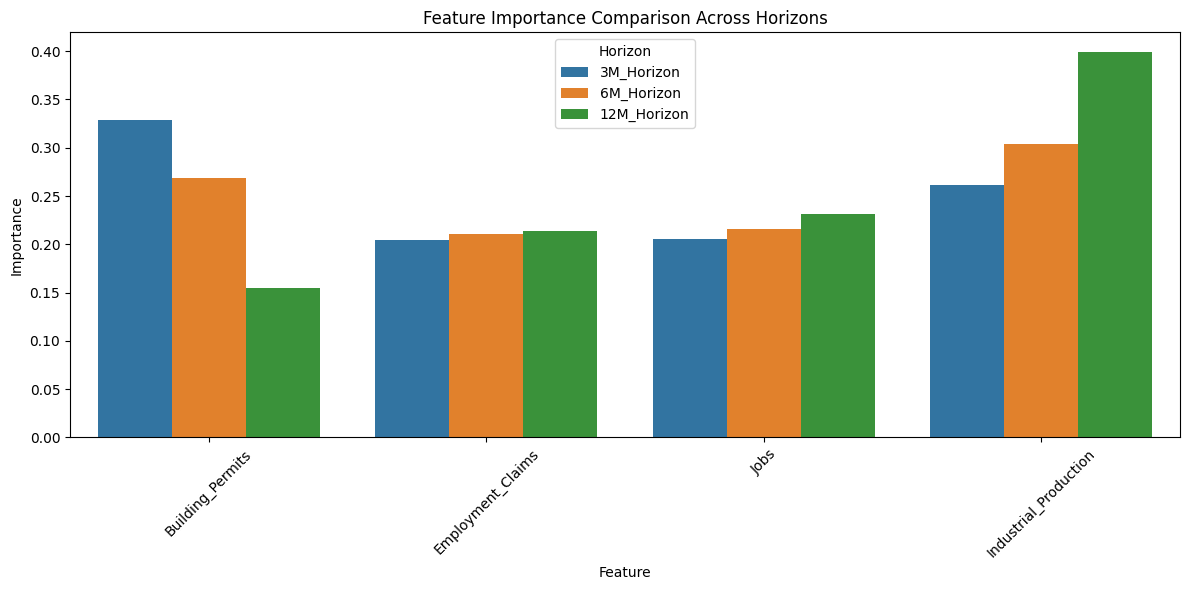

Feature Importance Comparison:
                 Feature  3M_Horizon  6M_Horizon  12M_Horizon
0       Building_Permits    0.328814    0.268607     0.155023
1      Employment_Claims    0.203968    0.210870     0.213834
2                   Jobs    0.205756    0.216148     0.231579
3  Industrial_Production    0.261462    0.304375     0.399564


In [33]:
# Create a comprehensive comparison
comparison_df = pd.DataFrame({
    'Feature': features,
    '3M_Horizon': model_3m.feature_importances_,
    '6M_Horizon': model_6m.feature_importances_,
    '12M_Horizon': model_12m.feature_importances_
})

# Melt for plotting
comparison_melted = comparison_df.melt(id_vars='Feature', 
                                      var_name='Horizon', 
                                      value_name='Importance')

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x='Feature', y='Importance', hue='Horizon')
plt.title('Feature Importance Comparison Across Horizons')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Feature Importance Comparison:")
print(comparison_df)

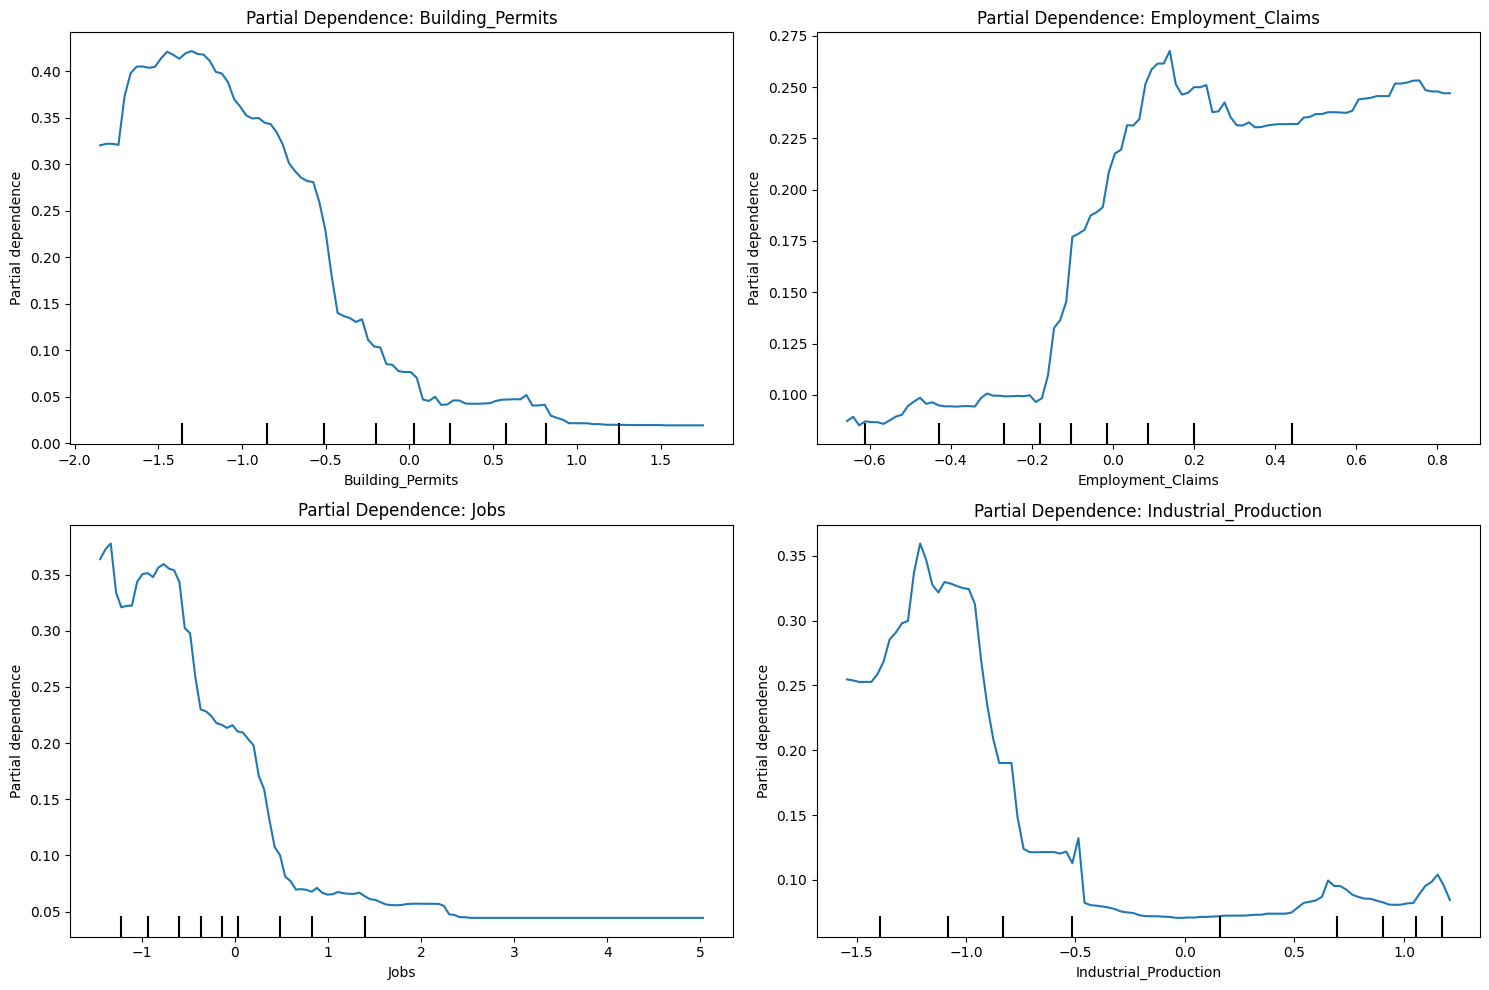

In [34]:
# Create partial dependence plots for each feature
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features):
    # Use 3-month model as example (repeat for other horizons if needed)
    PartialDependenceDisplay.from_estimator(
        model_3m, 
        X_train_scaled_3m, 
        [i], 
        feature_names=features,
        ax=axes[i]
    )
    axes[i].set_title(f'Partial Dependence: {feature}')

plt.tight_layout()
plt.show()

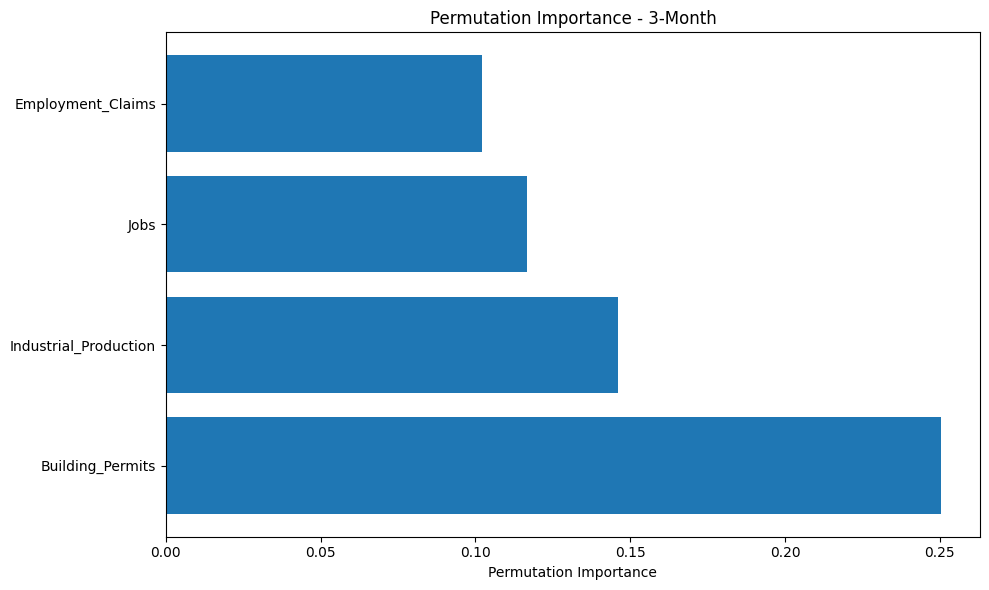

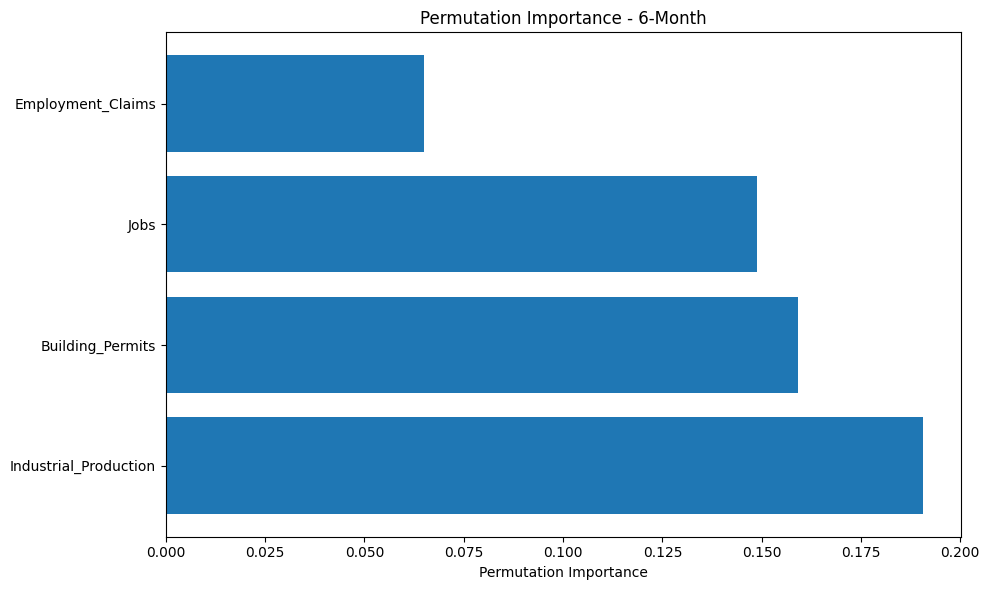

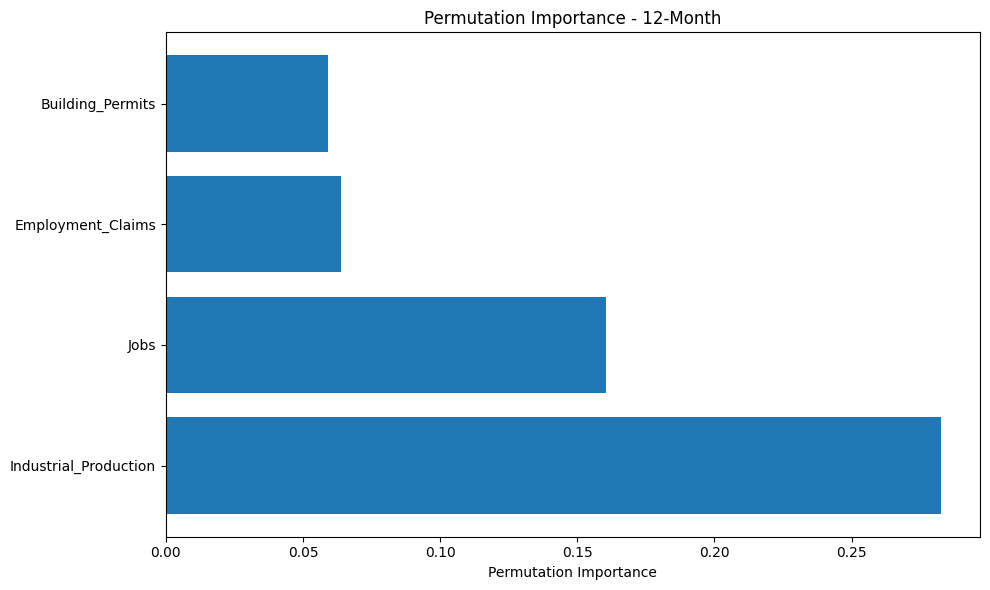

In [35]:
def calculate_permutation_importance(model, X_test, y_test, features, title):
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        n_repeats=10, 
        random_state=42,
        scoring='roc_auc'  # or 'accuracy', 'f1', etc.
    )
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Permutation Importance')
    plt.title(f'Permutation Importance - {title}')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Calculate permutation importance for each model
perm_3m = calculate_permutation_importance(model_3m, X_test_scaled_3m, y_test_3m, features, "3-Month")
perm_6m = calculate_permutation_importance(model_6m, X_test_scaled_6m, y_test_6m, features, "6-Month")
perm_12m = calculate_permutation_importance(model_12m, X_test_scaled_12m, y_test_12m, features, "12-Month")

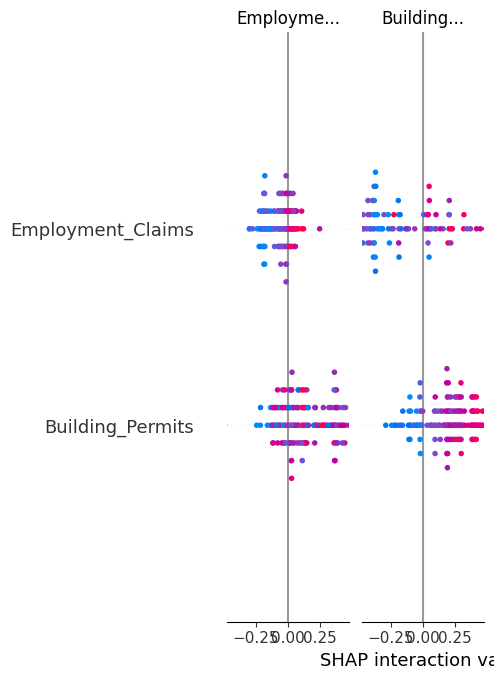

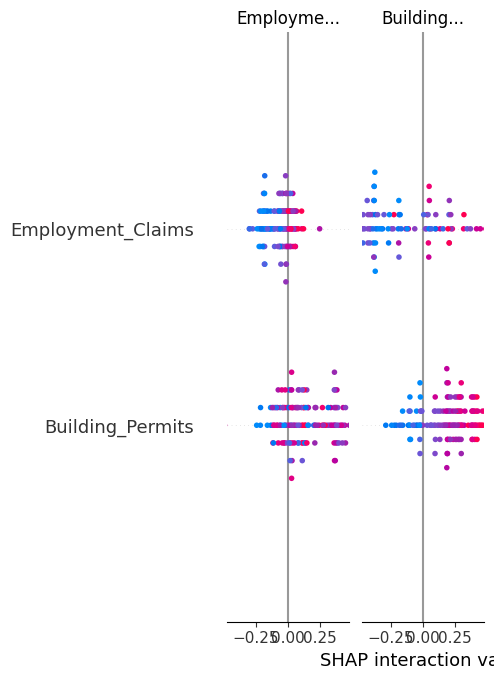

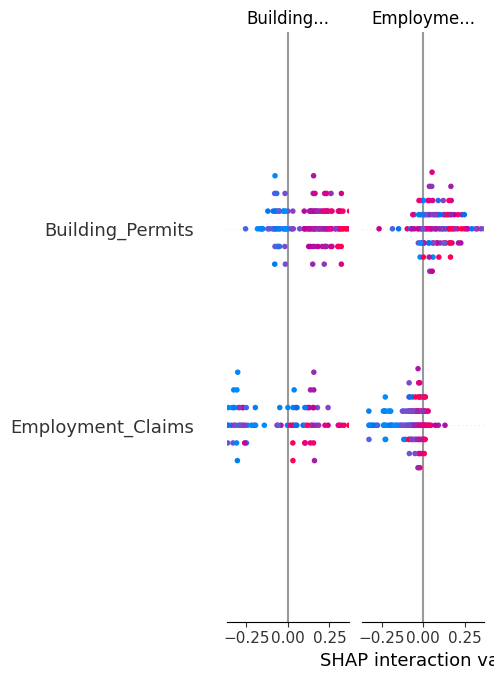

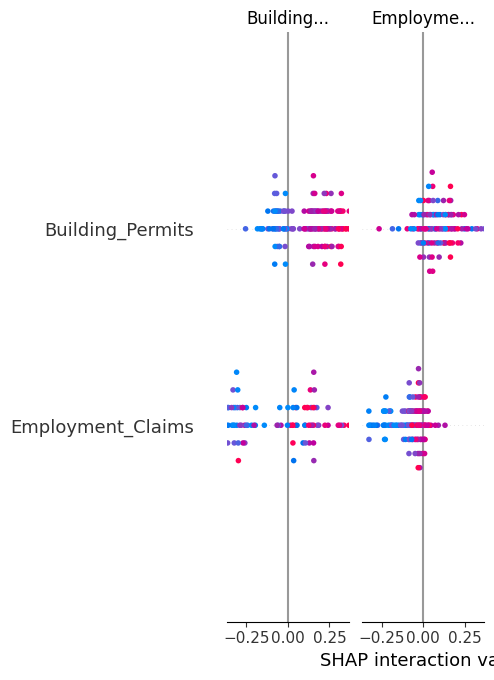

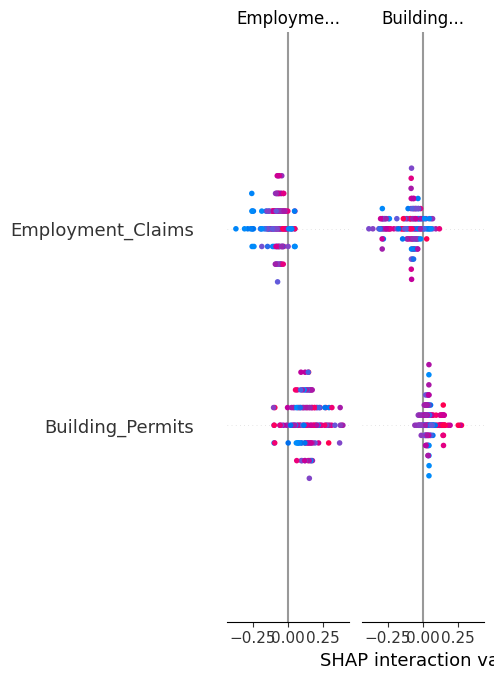

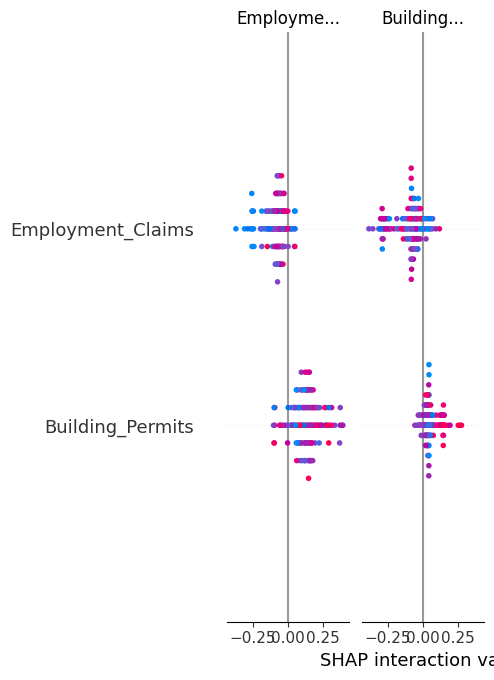

In [36]:
def analyze_shap_values(model, X_train, X_test, features, title):
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for test set
    shap_values = explainer.shap_values(X_test)
    
    # For binary classification, take the positive class
    if len(shap_values) == 2:
        shap_values = shap_values[1]  # Positive class
    
    # Summary plot
    shap.summary_plot(shap_values, X_test, feature_names=features, title=f'SHAP Summary - {title}')
    
    # Feature importance plot
    shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar", title=f'SHAP Feature Importance - {title}')
    
    return shap_values

# Analyze SHAP values for each model
shap_3m = analyze_shap_values(model_3m, X_train_scaled_3m, X_test_scaled_3m, features, "3-Month")
shap_6m = analyze_shap_values(model_6m, X_train_scaled_6m, X_test_scaled_6m, features, "6-Month")
shap_12m = analyze_shap_values(model_12m, X_train_scaled_12m, X_test_scaled_12m, features, "12-Month")